# Week 1 demo

In [1]:
# Load required libraries
import nltk
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Improve figure display
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.3)

Load extraction and cleanup functions.

In [2]:
def extract_about_project(text):
    # Extracts the 'About this project' blurb
    return ''.join(re.findall(
        r'(?<=About this project).*(?=Risks and challenges)',
        text
    ))

def extract_risks(text):
    # Extracts the 'Risks and challenges' blurb
    return ''.join(re.findall(
        r'(?<=Risks and challenges).*(?=Learn about accountability on Kickstarter)',
        text
    ))

def clean_up(messy_text):    
    # Shrinks all whitespace to a single space
    clean_text = re.sub(r'\s+', ' ', messy_text)
    
    # Removes leading and trailing whitespace
    clean_text = re.sub(r'^\s+|\s+?$', '', clean_text)
    
    # Removes the video warning in the scraped content
    return clean_text.replace(
        "You'll need an HTML5 capable browser to see this content. Play Replay with sound Play with sound 00:00 00:00",
        ''
    )

def scrape(hyperlink):
    # Scrape the HTML content from the website pointed by the hyperlink
    doc = requests.get(hyperlink)
    return BeautifulSoup(doc.text, 'html.parser')

def extract_sections(soup):    
    # Extract and clean up both sections
    return (
        clean_up(extract_about_project(soup.get_text().replace('\n', ' '))), 
        clean_up(extract_risks(soup.get_text().replace('\n', ' ')))
    )

def extract_features(text):
    # Compute all features and return them in a tuple
    return (
        len(tokenize_sentences(text)),
        count_all_caps(text),
        count_exclamations(text),
        len(tokenize_words(text)),
        compute_avg_words(text)
    )

Load feature engineering functions.

In [3]:
def tokenize_sentences(text):
    # Tokenizes text into sentences and returns them in a list
    return nltk.sent_tokenize(text)

def count_all_caps(text):
    # Counts the number of words in all-caps
    return len(re.findall(r'[A-Z]{2,}', text))

def count_exclamations(text):
    # Counts the number of exclamation marks present in the text
    return len(re.findall(r'!', text))

def remove_punc(text):
    # Returns the text with punctuation removed
    return re.sub(r'[^\w\d\s]', '', text)

def tokenize_words(text):
    # Tokenizes text into words and returns them in a list
    return nltk.word_tokenize(remove_punc(text))

def compute_avg_words(text):
    return pd.Series(
        [len(tokenize_words(sentence)) for sentence in \
         tokenize_sentences(text)]
    ).mean()

Initialize empty DataFrame for both text sections.

In [4]:
# Initialize empty DataFrames
about_project_df = pd.DataFrame(
    columns=['num_sents', 'num_all_caps', 'num_exclms', 'num_words', 
             'avg_words_per_sent']
)

risks_df = pd.DataFrame(
    columns=['num_sents', 'num_all_caps', 'num_exclms', 'num_words', 
             'avg_words_per_sent']
)

Load project data.

In [5]:
df = joblib.load('sample_extracted_web_robots_data.pkl')

# Convert `funded` column values into `string` type
df['funded'] = df['funded'].apply(str)

Take a random sample of the scraped data.

In [6]:
df_small = df.sample(100)

# Reset index labels
df_small = df_small.reset_index().drop('index', axis=1)

Perform scraping and compute how long it takes.

In [7]:
start = time.time()
for index in range(len(df_small)):
    hyperlink = df_small.loc[index]['hyperlink']
    
    # Extract sections
    about_project_text, risks_text = extract_sections(
        scrape(hyperlink)
    )
    
    # Extract features and load them into a DataFrame
    about_project_df.loc[index] = extract_features(about_project_text)
    risks_df.loc[index] = extract_features(risks_text)
time.time() - start

174.064293384552

Combine scraped data with original DataFrame.

In [8]:
joined_about = pd.concat(
    (df_small[['name', 'funded']], about_project_df), axis=1
)

joined_risks = pd.concat(
    (df_small[['name', 'funded']], risks_df), axis=1
)

Dump the scraped data.

In [9]:
joblib.dump(joined_about, 'scraped_about_project.pkl')
joblib.dump(joined_risks, 'scraped_risks.pkl')

['2017-09-07 scraped_risks.pkl']

Visualize correlations and distributions in the features for the *About this Project* section.

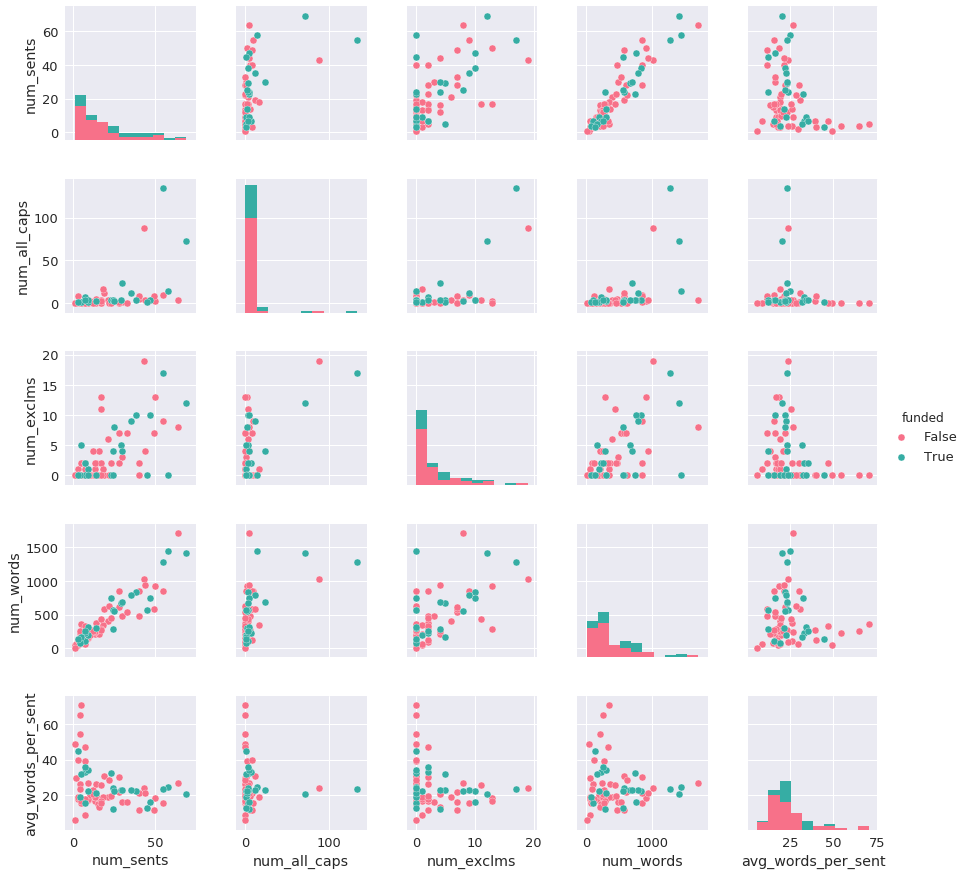

In [10]:
# Display a pairplot 
sns.pairplot(
    data=joined_about.dropna(),
    hue='funded',
    palette='husl'
);

Visualize correlations and distributions in the features for the *Risks and Challenges* section.

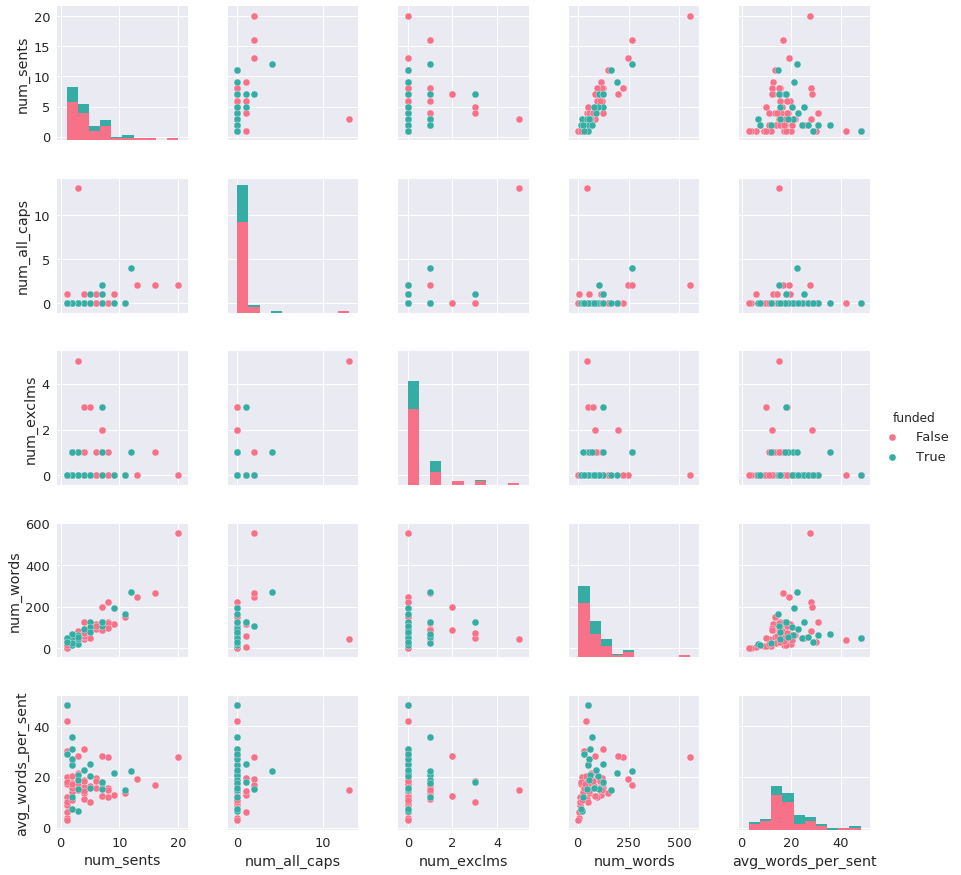

In [11]:
# Display a pairplot 
sns.pairplot(
    data=joined_risks.dropna(),
    hue='funded',
    palette='husl'
);